*Title: Analysing Tropospheric Formaldehyde (HCHO) gas in Sri Lanka*

*Author: Benura Wickramanayake 💻*

*Date: 2024-03-25*

In [117]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DateType, DoubleType, StringType
from pyspark.sql.functions import isnan, sum as Fsum
from pyspark.sql import functions as F
import pyspark_dist_explore as pdx
from pyspark_dist_explore import hist
from pyspark.sql.functions import avg, when

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### PySpark Environment

In [118]:
# create a Spark session
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()

## Create Dataframe

Reference - https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html

Defined schema of the dataset with data types for each column, load 3 csv files (dataset) into DataFrame  

In [119]:
# Define the schema
schema = StructType([
    StructField("HCHO_reading", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("Current_Date", DateType(), True),
    StructField("Next_Date", DateType(), True)
])

In [120]:
# load data
file_paths = [
    "Dataset\\col_mat_nuw_output.csv",
    "Dataset\\mon_kur_jaf_output.csv",
    "Dataset\\kan_output.csv"
]

In [121]:
# dataframe creation
df = spark.read.csv(file_paths, schema=schema, header=True)

### Dataset Observations

In [122]:
# data types of columns in the DataFrame
data_types = df.dtypes

for col_name, col_type in data_types:
    print(f"'{col_name}' column data type - '{col_type}'")

'HCHO_reading' column data type - 'double'
'Location' column data type - 'string'
'Current_Date' column data type - 'date'
'Next_Date' column data type - 'date'


In [123]:
# df summary
df_summary = df.describe()
df_summary.show()

+-------+--------------------+-------------------+
|summary|        HCHO_reading|           Location|
+-------+--------------------+-------------------+
|  count|                7916|              12779|
|   mean|1.192609008729181...|               NULL|
| stddev|9.322891110805865E-5|               NULL|
|    min|-3.52473024357239...| Bibile, Monaragala|
|    max|8.997101837438971E-4|Nuwara Eliya Proper|
+-------+--------------------+-------------------+



In [124]:
# DF size
# rows
num_rows = df.count()
# columns
num_cols = len(df.columns)

print(f"Size of the DataFrame: ({num_rows}, {num_cols})")

Size of the DataFrame: (12779, 4)


In [125]:
# see first 50 rows
df.show(50, truncate=False)   #truncate - readability

+----------------------+------------------+------------+----------+
|HCHO_reading          |Location          |Current_Date|Next_Date |
+----------------------+------------------+------------+----------+
|1.919914652467399E-5  |Bibile, Monaragala|2019-01-02  |2019-01-03|
|2.8114479359302837E-5 |Bibile, Monaragala|2019-01-03  |2019-01-04|
|3.747998184385943E-5  |Bibile, Monaragala|2019-01-04  |2019-01-05|
|-1.7982608793453114E-5|Bibile, Monaragala|2019-01-05  |2019-01-06|
|1.4578368961799026E-4 |Bibile, Monaragala|2019-01-06  |2019-01-07|
|2.8285908025465342E-5 |Bibile, Monaragala|2019-01-07  |2019-01-08|
|NULL                  |Bibile, Monaragala|2019-01-08  |2019-01-09|
|1.4208501670509577E-4 |Bibile, Monaragala|2019-01-09  |2019-01-10|
|NULL                  |Bibile, Monaragala|2019-01-10  |2019-01-11|
|2.014587947072581E-5  |Bibile, Monaragala|2019-01-11  |2019-01-12|
|1.5827876632101837E-4 |Bibile, Monaragala|2019-01-12  |2019-01-13|
|NULL                  |Bibile, Monaragala|2019-

In [126]:
# unique values of location column
unique_locations = df.select("Location").distinct()
unique_locations.show()

+-------------------+
|           Location|
+-------------------+
|  Kurunegala Proper|
| Bibile, Monaragala|
|      Jaffna Proper|
|   Deniyaya, Matara|
|     Colombo Proper|
|Nuwara Eliya Proper|
|       Kandy Proper|
+-------------------+



## PreProcessing

## Convert DF into pandas DF

Reference - https://spark.apache.org/docs/latest/sql-data-sources-load-save-functions.html,https://stackoverflow.com/questions/50958721/convert-a-spark-dataframe-to-pandas-df, https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.shuffle.html  

In [127]:
# PySpark df to pandas df
pandas_df = df.toPandas()

# convert data types in pandas df
pandas_df['Location'] = pandas_df['Location'].astype(str)
pandas_df['HCHO_reading'] = pandas_df['HCHO_reading'].astype(float)
pandas_df['Current_Date'] = pd.to_datetime(pandas_df['Current_Date'])
pandas_df['Next_Date'] = pd.to_datetime(pandas_df['Next_Date'])

In [128]:
# save pandas df 
csv_file_path = "DataFrame/unprocessed_df.csv"
pandas_df.to_csv(csv_file_path, index=False)

In [129]:
pandas_df.head(20)

,HCHO_reading,Location,Current_Date,Next_Date
0,0.000019,"Bibile, Monaragala",2019-01-02,2019-01-03
1,0.000028,"Bibile, Monaragala",2019-01-03,2019-01-04
2,0.000037,"Bibile, Monaragala",2019-01-04,2019-01-05
3,-0.000018,"Bibile, Monaragala",2019-01-05,2019-01-06
4,0.000146,"Bibile, Monaragala",2019-01-06,2019-01-07
5,0.000028,"Bibile, Monaragala",2019-01-07,2019-01-08
6,NaN,"Bibile, Monaragala",2019-01-08,2019-01-09
7,0.000142,"Bibile, Monaragala",2019-01-09,2019-01-10
8,NaN,"Bibile, Monaragala",2019-01-10,2019-01-11
9,0.000020,"Bibile, Monaragala",2019-01-11,2019-01-12


In [130]:
pandas_df.dtypes

HCHO_reading           float64
Location                object
Current_Date    datetime64[ns]
Next_Date       datetime64[ns]
dtype: object

In [131]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12779 entries, 0 to 12778
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   HCHO_reading  7916 non-null   float64       
 1   Location      12779 non-null  object        
 2   Current_Date  12779 non-null  datetime64[ns]
 3   Next_Date     12779 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 399.5+ KB


## 1.Check unique values of each column to get idea about DF

In [132]:
for col in pandas_df.columns:
    unique_values = pandas_df[col].unique()
    
    print(f"Column: {col}")
    for val in unique_values:
        print(val)
    print("---------------")

Column: HCHO_reading
1.919914652467399e-05
2.8114479359302837e-05
3.747998184385943e-05
-1.7982608793453114e-05
0.00014578368961799026
2.8285908025465342e-05
nan
0.00014208501670509577
2.014587947072581e-05
0.00015827876632101837
9.952823849642218e-05
7.484570960514249e-05
7.736112226328797e-05
3.9881410104076654e-05
0.00018916202038533428
0.00011599699264237457
0.00014135236237093095
7.165379525100222e-05
-2.8553898678860067e-05
0.00018056736899607327
9.113160086427455e-05
7.241739856355372e-05
4.098144742473462e-05
5.186428352058307e-05
1.0513533806196861e-05
4.076109671524861e-05
7.59353421234044e-05
7.34858268449358e-05
1.0584419214865193e-05
6.919795120446755e-05
0.00016234806389547884
2.6644206895973665e-05
0.00013624131982837749
5.895095797941796e-05
7.990708924877695e-05
8.647263683420719e-05
6.580490440211678e-05
0.00011733176797156996
0.00013726642237273966
0.00011835877319569628
-4.671209171647206e-05
0.00020152217994513967
0.00023333786018048562
0.00011305602340930811
8.923

HCHO_reading column has negative, postive and Null values. So we have to handle Null values and Negative values

## 2. Handle negative values

HCHO (formaldehyde) measurements cannot include negative values - https://www.mdpi.com/1996-1073/15/20/7680#:~:text=In%20the%20case%20that%20the,background%20noise%20to%20the%20emissions.

Convert negative values into null values and handle with null values

In [133]:
# negative value count
negative_count = (pandas_df['HCHO_reading'] < 0).sum()

#null value count
null_count = pandas_df['HCHO_reading'].isnull().sum()

print(f"Number of negative values in 'HCHO_reading' column: {negative_count}")
print(f"Number of null values in 'HCHO_reading' column: {null_count}")

Number of negative values in 'HCHO_reading' column: 563
Number of null values in 'HCHO_reading' column: 4863


In [134]:
pandas_df['HCHO_reading'] = pandas_df['HCHO_reading'].apply(lambda x: x if x >= 0 else None)

In [135]:
#check again negative and null count

negative_count = (pandas_df['HCHO_reading'] < 0).sum()
null_count = pandas_df['HCHO_reading'].isnull().sum()

print(f"Number of negative values in 'HCHO_reading' column: {negative_count}")
print(f"Number of null values in 'HCHO_reading' column: {null_count}")

Number of negative values in 'HCHO_reading' column: 0
Number of null values in 'HCHO_reading' column: 5426


All the negative HCHO values converted into null type

In [136]:
pandas_df.head()

,HCHO_reading,Location,Current_Date,Next_Date
0,0.000019,"Bibile, Monaragala",2019-01-02,2019-01-03
1,0.000028,"Bibile, Monaragala",2019-01-03,2019-01-04
2,0.000037,"Bibile, Monaragala",2019-01-04,2019-01-05
3,NaN,"Bibile, Monaragala",2019-01-05,2019-01-06
4,0.000146,"Bibile, Monaragala",2019-01-06,2019-01-07


## 3. Handle NULL values

In [137]:
num_records = pandas_df.shape[0]
print(f"Number of records in DataFrame: {num_records}")

Number of records in DataFrame: 12779


Full dataset has 12779 rows. 5426 rows have NULL values. We cant drop those rows bcz it has around 1/3 of full dataframe. So we should handle those values.

This is a time series dataset. So we can use LOCF (Last Observation Carried Forward) or NOCB (Next Observation Carried Backward) methods to handle Null values

In [138]:
# Fill null values using LOCF (Last Observation Carried Forward) method
pandas_df['HCHO_reading'] = pandas_df['HCHO_reading'].ffill()

In [139]:
#check null values
null_count = pandas_df['HCHO_reading'].isnull().sum()
print(f"Number of null values in 'HCHO_reading' column: {null_count}")

Number of null values in 'HCHO_reading' column: 0


## 4. Handle Duplicates

In [140]:
# count occurrences of each unique row
duplicate_counts = pandas_df.duplicated().sum()

print(f"Total number of duplicate data points: {duplicate_counts}")

Total number of duplicate data points: 0


So there are no any duplicate data points.

## 5. Handle Outliers

Reference - https://www.machinelearningplus.com/pyspark/pyspark-outlier-detection-and-treatment/

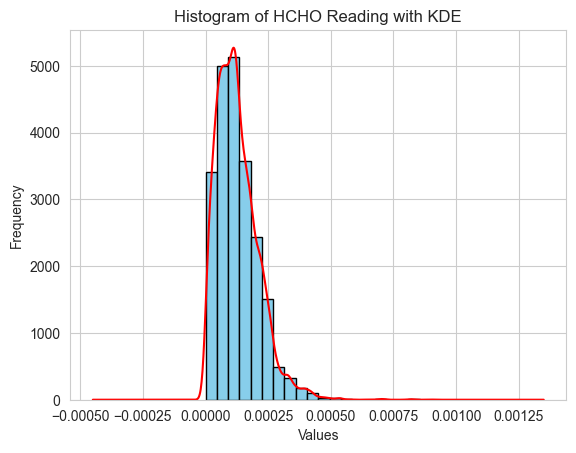

In [141]:
column_values = pandas_df['HCHO_reading']

plt.hist(column_values, bins=20, color='skyblue', edgecolor='black', density=True)  # density=True

# Add a line to identify the curve
column_values.plot(kind='kde', linestyle='-', color='red')  # kernel density estimate (KDE) 

# labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of HCHO Reading with KDE')

# show plot
plt.show()


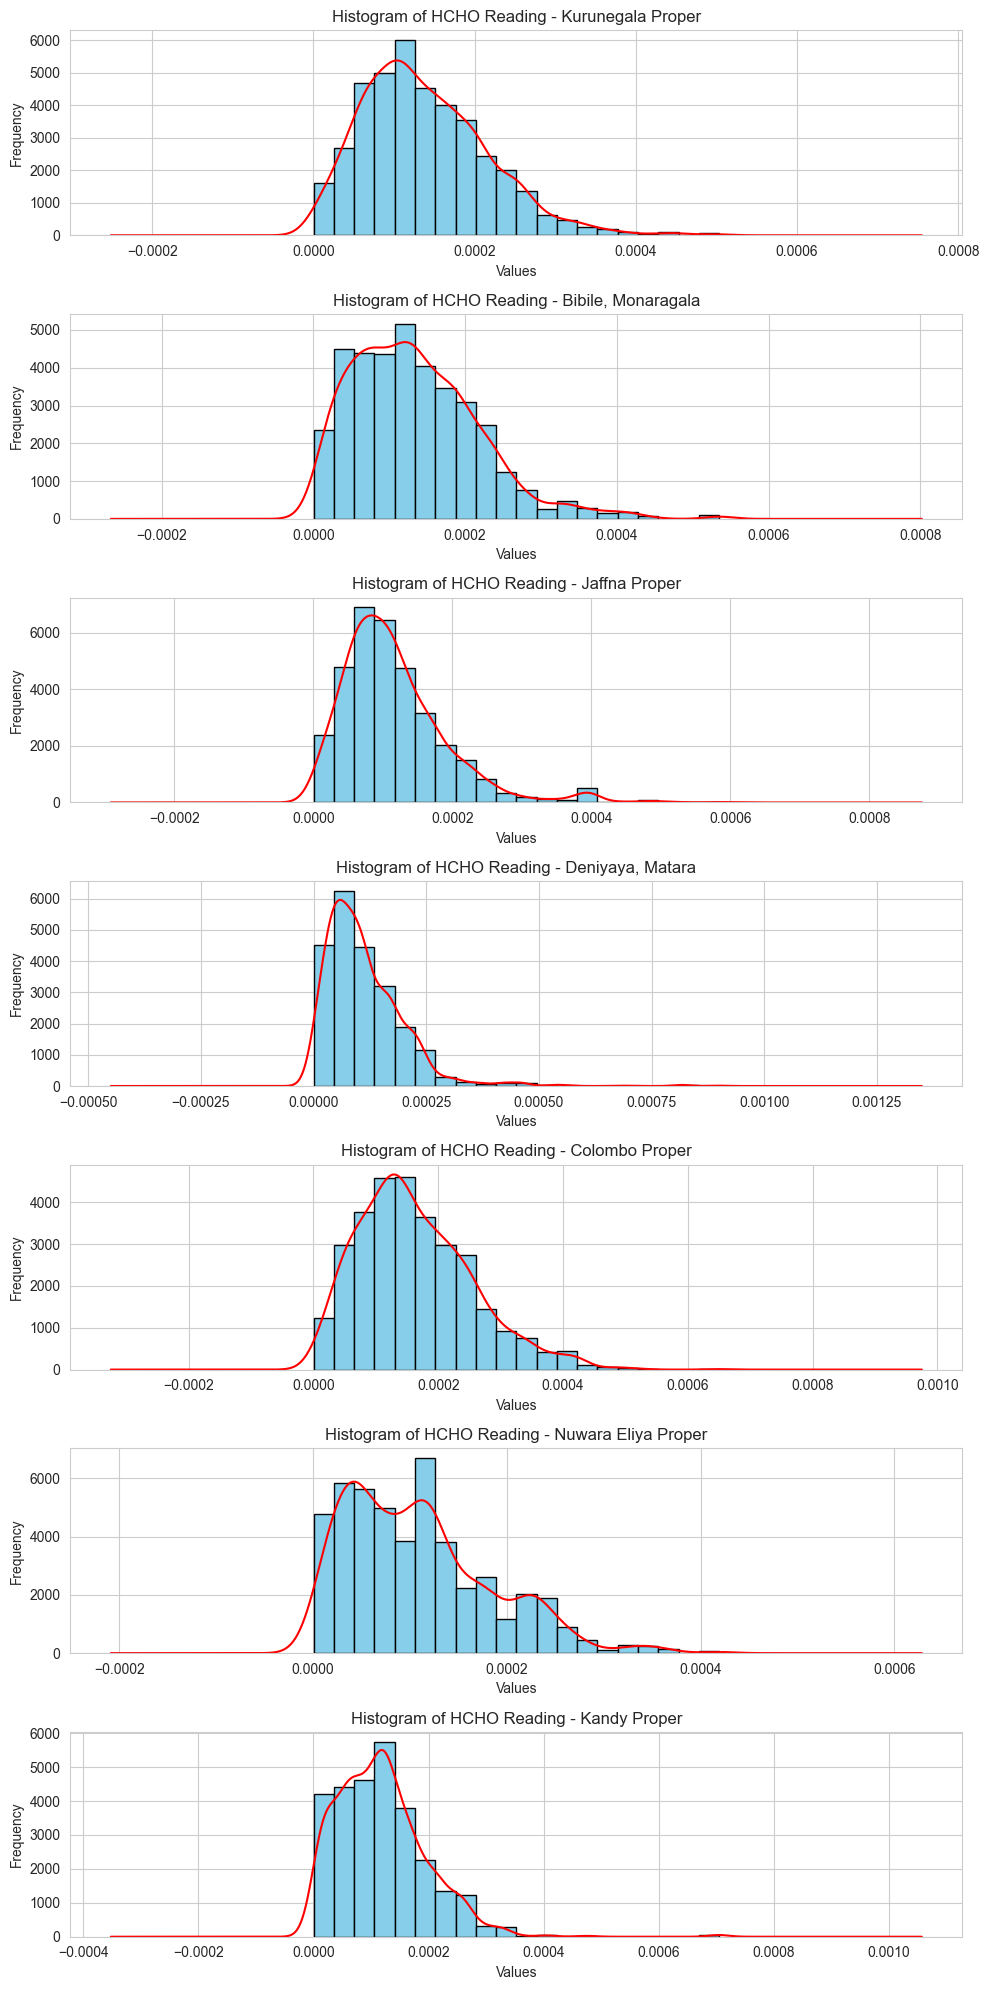

In [142]:
# list of locations 
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

# subplots for each location
fig, axs = plt.subplots(len(locations), figsize=(10, 20))

# histograms for each location
for i, location in enumerate(locations):
    # filter df for the current location
    location_df = pandas_df[pandas_df['Location'] == location]
    
    # extract values 
    column_values = location_df['HCHO_reading']
    
    # histogram for the current location
    axs[i].hist(column_values, bins=20, color='skyblue', edgecolor='black', density=True)  # plot density histogram
    column_values.plot(kind='kde', linestyle='-', color='red', ax=axs[i])  # KDE
    
    # set title, labels, and grid for the plot
    axs[i].set_title(f'Histogram of HCHO Reading - {location}')
    axs[i].set_xlabel('Values')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

# adjust layout and display the plot
plt.tight_layout()
plt.show()

## Boxplot of HCHO reading

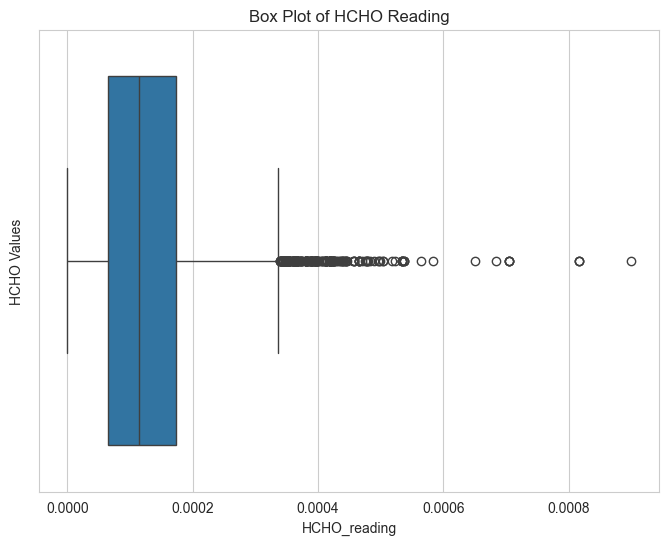

In [143]:
# Extract the values from the DataFrame column
column_values = pandas_df['HCHO_reading']

# Set up the figure and axes
plt.figure(figsize=(8, 6))

# Plot the box plot
sns.boxplot(x=column_values)

# Add labels and title
plt.ylabel('HCHO Values')
plt.title('Box Plot of HCHO Reading')

# Show the plot
plt.show()

## Boxplot of each location

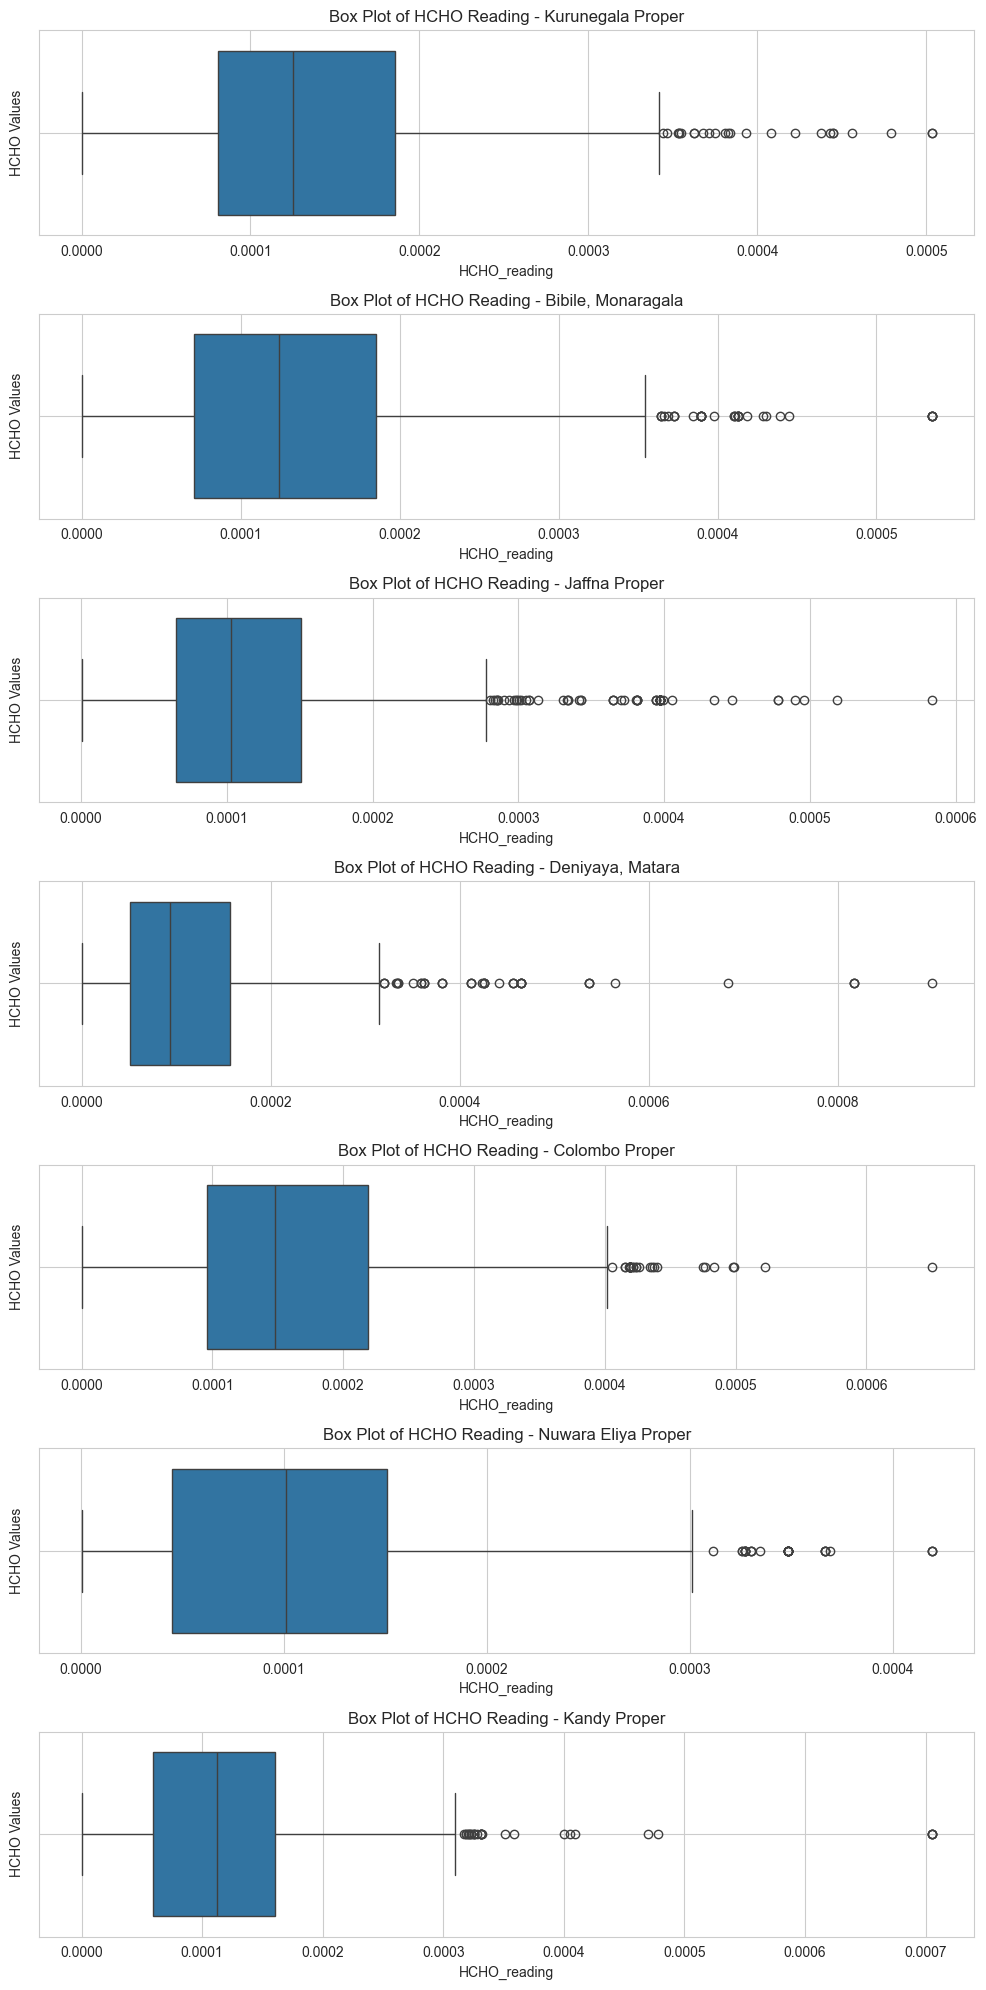

In [144]:
# List of locations for which you want to plot box plots
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

# Create subplots for each location
fig, axs = plt.subplots(len(locations), figsize=(10, 20))

# Plot box plots for each location
for i, location in enumerate(locations):
    # Filter DataFrame for the current location
    location_df = pandas_df[pandas_df['Location'] == location]
    
    # Extract values from the filtered DataFrame
    column_values = location_df['HCHO_reading']
    
    # box plot
    sns.boxplot(x=column_values, ax=axs[i])
    axs[i].set_title(f'Box Plot of HCHO Reading - {location}')
    axs[i].set_ylabel('HCHO Values')
    axs[i].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Handle outliers of HCHO_reading column based on Location

In [145]:
# list of locations
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

In [146]:
# function to handle outliers using IQR method for each location
def handle_outliers_by_location(pandas_df, location):
    # get current location
    location_df = pandas_df[pandas_df['Location'] == location]
    
    # calculate Q1 and Q3 for HCHO_reading column
    Q1 = location_df['HCHO_reading'].quantile(0.25)
    Q3 = location_df['HCHO_reading'].quantile(0.75)
    
    # calculate IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # lower and upper bounds 
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Display lower and upper bounds
    print(f"Location: {location}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print("")
    
    # replace outlier values with the lower or upper bound
    location_df.loc[location_df['HCHO_reading'] < lower_bound, 'HCHO_reading'] = lower_bound
    location_df.loc[location_df['HCHO_reading'] > upper_bound, 'HCHO_reading'] = upper_bound
    
    return location_df

In [147]:
# use handle_outliers_by_location function for each location and concatenate the results
processed_dfs = [handle_outliers_by_location(pandas_df, location) for location in locations]
processed_df = pd.concat(processed_dfs)

print(processed_df)

Location: Kurunegala Proper
Lower Bound: -7.688146469391387e-05
Upper Bound: 0.0003432216167136211

Location: Bibile, Monaragala
Lower Bound: -0.00010007991717437966
Upper Bound: 0.00035612784169470517

Location: Jaffna Proper
Lower Bound: -6.348765947766678e-05
Upper Bound: 0.0002790853840722029

Location: Deniyaya, Matara
Lower Bound: -0.00010700392289743703
Upper Bound: 0.00031446956725475874

Location: Colombo Proper
Lower Bound: -8.915831934899112e-05
Upper Bound: 0.00040410236334236535

Location: Nuwara Eliya Proper
Lower Bound: -0.00011424007674018923
Upper Bound: 0.00031000657864374917

Location: Kandy Proper
Lower Bound: -9.288074621061974e-05
Upper Bound: 0.00031261765511941147

       HCHO_reading           Location Current_Date  Next_Date
1825       0.000088  Kurunegala Proper   2019-01-01 2019-01-02
1826       0.000137  Kurunegala Proper   2019-01-02 2019-01-03
1827       0.000148  Kurunegala Proper   2019-01-03 2019-01-04
1828       0.000148  Kurunegala Proper   2019-01-0

### Check boxplot after handeling outliers

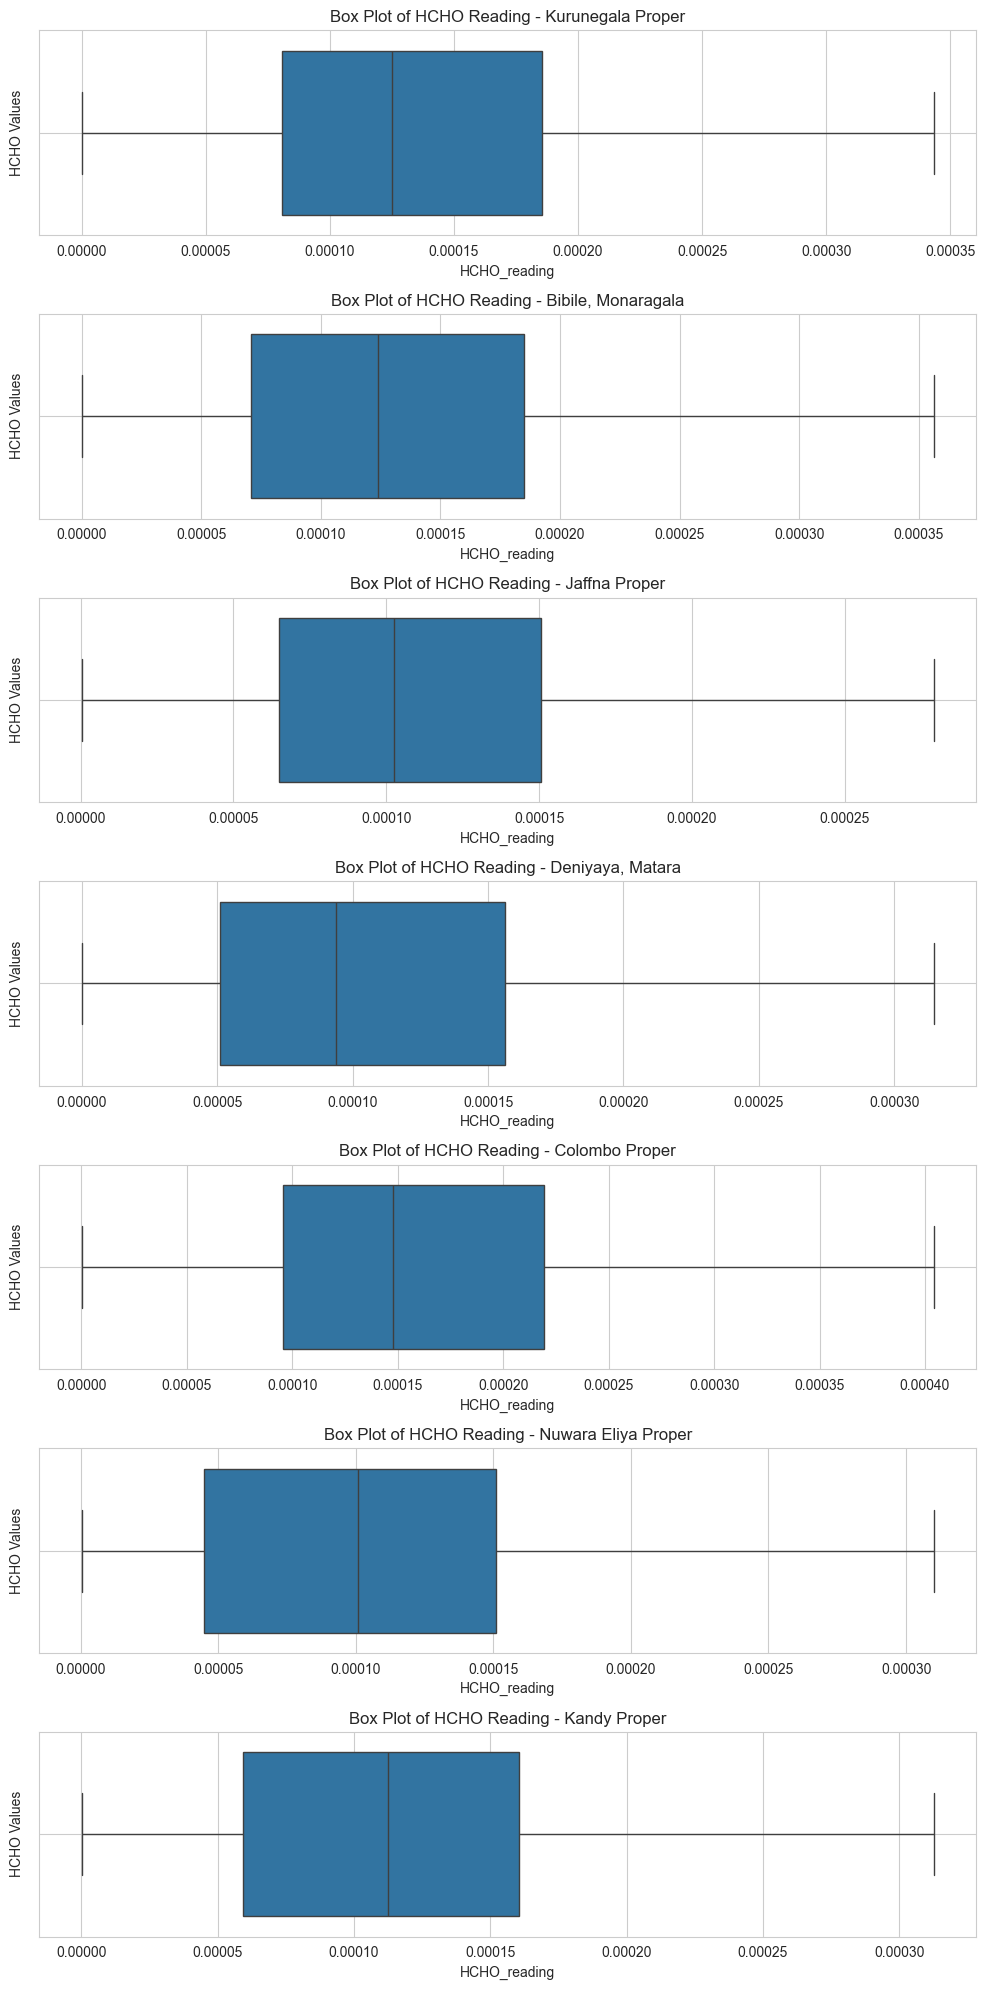

In [148]:
# list of locations
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

# creating subplots for each location
fig, axs = plt.subplots(len(locations), figsize=(10, 20))

# box plots for each location
for i, location in enumerate(locations):
    # get location
    location_df = processed_df[processed_df['Location'] == location]
    
    # get values from filtered location DF
    column_values = location_df['HCHO_reading']
    
    # box plot
    sns.boxplot(x=column_values, ax=axs[i])
    axs[i].set_title(f'Box Plot of HCHO Reading - {location}')
    axs[i].set_ylabel('HCHO Values')
    axs[i].grid(True)

# adjust layout and display the plot
plt.tight_layout()
plt.show()

In [149]:
processed_df.head()

,HCHO_reading,Location,Current_Date,Next_Date
1825,0.000088,Kurunegala Proper,2019-01-01,2019-01-02
1826,0.000137,Kurunegala Proper,2019-01-02,2019-01-03
1827,0.000148,Kurunegala Proper,2019-01-03,2019-01-04
1828,0.000148,Kurunegala Proper,2019-01-04,2019-01-05
1829,0.000249,Kurunegala Proper,2019-01-05,2019-01-06


### HCHO reading distribution after handeling outliers 

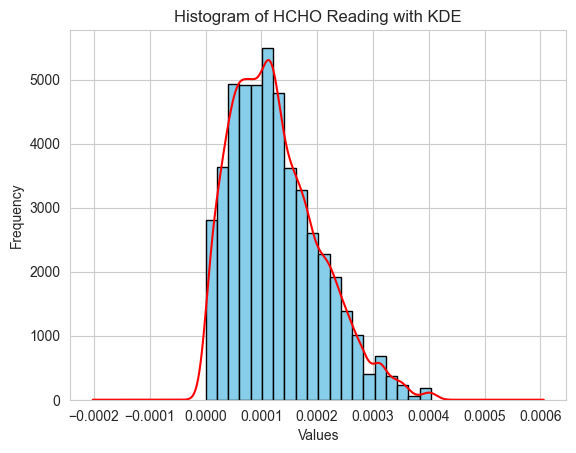

In [150]:
column_values = processed_df['HCHO_reading']

plt.hist(column_values, bins=20, color='skyblue', edgecolor='black', density=True)  # density=True

# Add a line to identify the curve
column_values.plot(kind='kde', linestyle='-', color='red')  # kernel density estimate (KDE) 

# labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of HCHO Reading with KDE')

# show plot
plt.show()

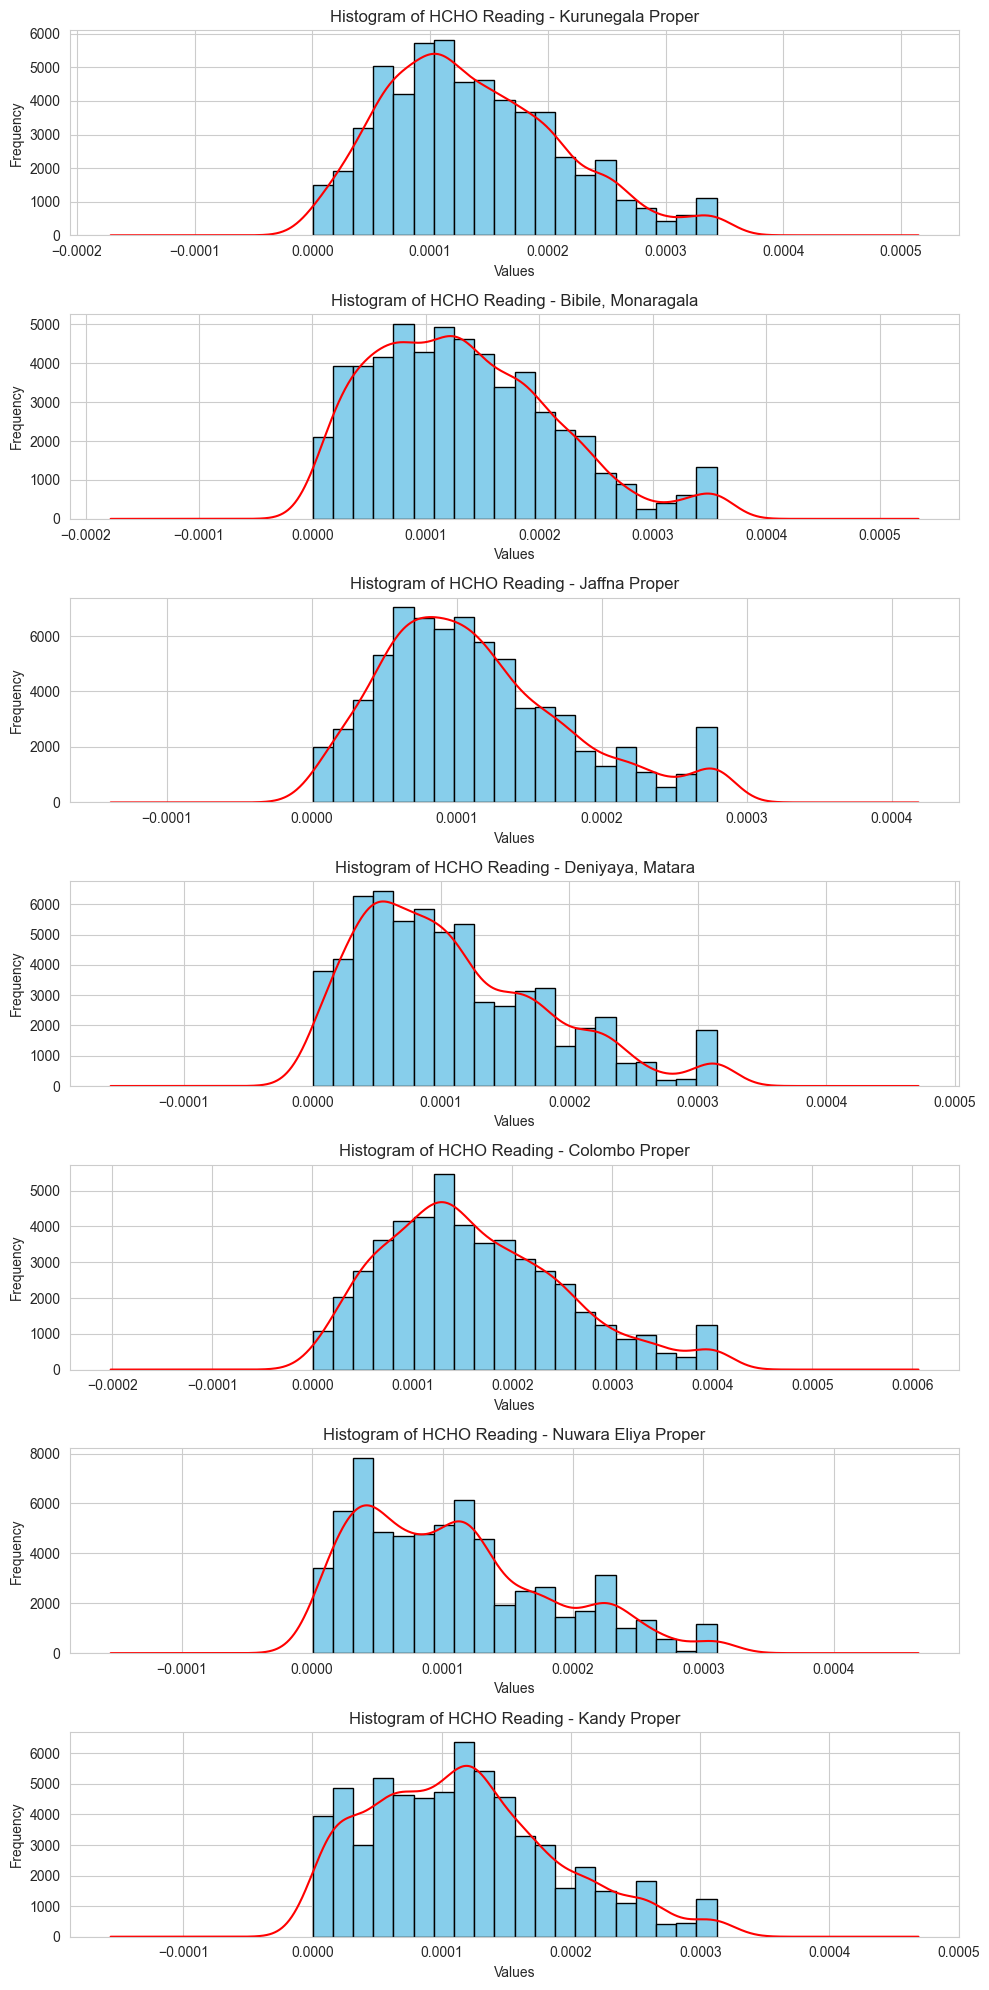

In [151]:
# list of locations 
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

# subplots for each location
fig, axs = plt.subplots(len(locations), figsize=(10, 20))

# histograms for each location
for i, location in enumerate(locations):
    # filter df for the current location
    location_df = processed_df[processed_df['Location'] == location]
    
    # extract values 
    column_values = location_df['HCHO_reading']
    
    # histogram for the current location
    axs[i].hist(column_values, bins=20, color='skyblue', edgecolor='black', density=True)  # plot density histogram
    column_values.plot(kind='kde', linestyle='-', color='red', ax=axs[i])  # KDE
    
    # set title, labels, and grid for the plot
    axs[i].set_title(f'Histogram of HCHO Reading - {location}')
    axs[i].set_xlabel('Values')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

# adjust layout and display the plot
plt.tight_layout()
plt.show()

## 6. Format inconsistencies

### Date columns

In [152]:
# convert Current_Date and Next_Date columns to datetime format
processed_df['Current_Date'] = pd.to_datetime(processed_df['Current_Date'])
processed_df['Next_Date'] = pd.to_datetime(processed_df['Next_Date'])

### Location column

In [153]:
# convert Location column to lowercase
processed_df['Location'] = processed_df['Location'].str.lower()

# remove leading and trailing whitespaces from Location column
processed_df['Location'] = processed_df['Location'].str.strip()

## 7. Save DF

In [154]:
# save pandas df 
csv_file_path = "DataFrame/processed_df.csv"
processed_df.to_csv(csv_file_path, index=False)

## 8. Exploring descriptive statistics 

### Before & After cleaning

In [156]:
# load unprocessed and processed datasets
unprocessed_df = pd.read_csv('DataFrame/unprocessed_df.csv')
processed_df = pd.read_csv('DataFrame/processed_df.csv')

### Overall statistics

In [161]:
# before cleaning
overall_stats_before = unprocessed_df['HCHO_reading'].describe()
print("Overall Descriptive Statistics for HCHO Levels (before cleaning):")
print(overall_stats_before)

Overall Descriptive Statistics for HCHO Levels (before cleaning):
count    7916.000000
mean        0.000119
std         0.000093
min        -0.000352
25%         0.000061
50%         0.000112
75%         0.000172
max         0.000900
Name: HCHO_reading, dtype: float64


In [162]:
# after cleaning
overall_stats_after = processed_df['HCHO_reading'].describe()
print("\nOverall Descriptive Statistics for HCHO Levels (after cleaning):")
print(overall_stats_after)


Overall Descriptive Statistics for HCHO Levels (after cleaning):
count    1.277900e+04
mean     1.255888e-04
std      7.838295e-05
min      8.485600e-08
25%      6.476921e-05
50%      1.138953e-04
75%      1.738711e-04
max      4.041024e-04
Name: HCHO_reading, dtype: float64


### Group by locations

In [163]:
# before cleaning
stats_before_cleaning = unprocessed_df.groupby('Location')['HCHO_reading'].describe()
print("Descriptive Statistics for HCHO Levels (before cleaning):")
print(stats_before_cleaning)

Descriptive Statistics for HCHO Levels (before cleaning):
                      count      mean       std       min       25%       50%  \
Location                                                                        
Bibile, Monaragala   1131.0  0.000126  0.000094 -0.000239  0.000069  0.000125   
Colombo Proper       1338.0  0.000159  0.000099 -0.000229  0.000093  0.000151   
Deniyaya, Matara      979.0  0.000092  0.000097 -0.000259  0.000037  0.000081   
Jaffna Proper        1461.0  0.000109  0.000078 -0.000352  0.000063  0.000102   
Kandy Proper         1032.0  0.000106  0.000092 -0.000300  0.000050  0.000106   
Kurunegala Proper    1234.0  0.000134  0.000087 -0.000157  0.000078  0.000127   
Nuwara Eliya Proper   741.0  0.000088  0.000084 -0.000179  0.000034  0.000082   

                          75%       max  
Location                                 
Bibile, Monaragala   0.000185  0.000535  
Colombo Proper       0.000221  0.000650  
Deniyaya, Matara     0.000139  0.000900  
Ja

In [164]:
# after cleaning
stats_after_cleaning = processed_df.groupby('Location')['HCHO_reading'].describe()
print("\nDescriptive Statistics for HCHO Levels (after cleaning):")
print(stats_after_cleaning)


Descriptive Statistics for HCHO Levels (after cleaning):
                      count      mean       std           min       25%  \
Location                                                                  
bibile, monaragala   1825.0  0.000133  0.000081  1.461232e-07  0.000071   
colombo proper       1825.0  0.000162  0.000090  2.111934e-07  0.000096   
deniyaya, matara     1826.0  0.000109  0.000074  8.485600e-08  0.000051   
jaffna proper        1826.0  0.000113  0.000065  4.103467e-07  0.000065   
kandy proper         1825.0  0.000117  0.000073  1.569671e-07  0.000059   
kurunegala proper    1826.0  0.000137  0.000075  1.433376e-07  0.000081   
nuwara eliya proper  1826.0  0.000108  0.000073  4.363303e-07  0.000045   

                          50%       75%       max  
Location                                           
bibile, monaragala   0.000124  0.000185  0.000356  
colombo proper       0.000148  0.000219  0.000404  
deniyaya, matara     0.000094  0.000156  0.000314  
jaffna

### Analyze distribution

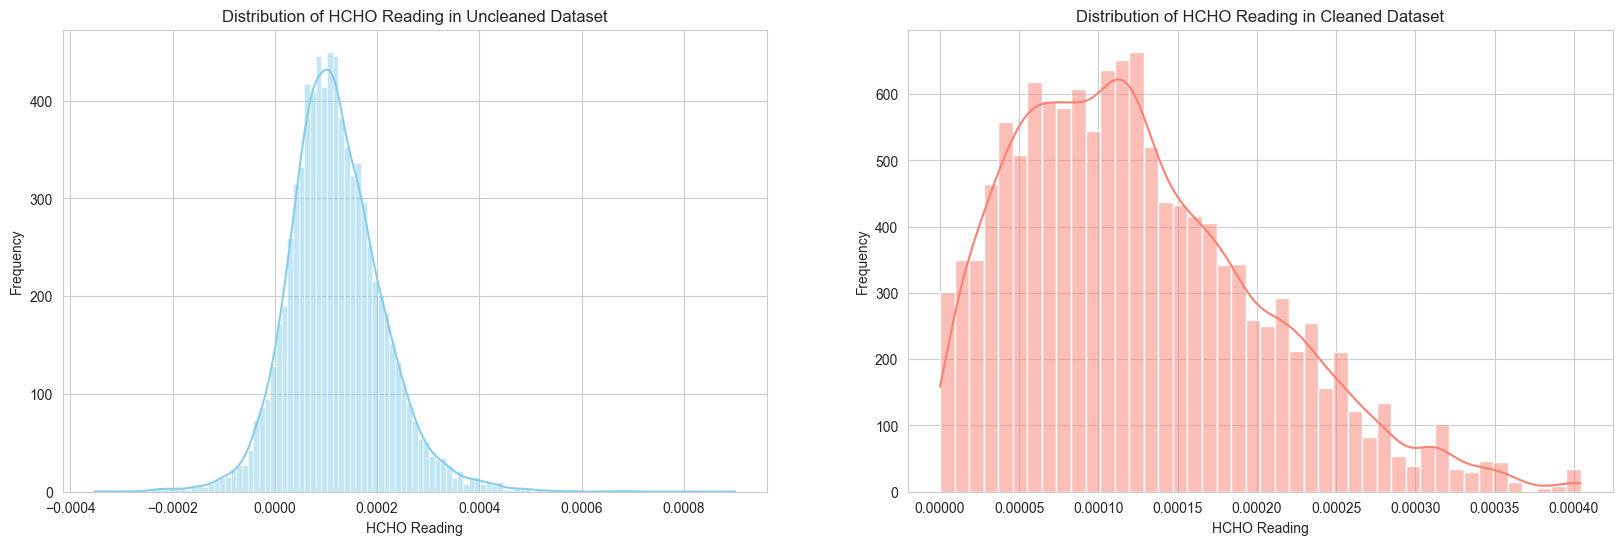

In [165]:
# Creating a figure with 2 subplots
plt.figure(figsize=(20, 6))

# Plot for the uncleaned dataset
plt.subplot(1, 2, 1)
sns.histplot(unprocessed_df["HCHO_reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading in Uncleaned Dataset')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')

# Plot for the cleaned dataset
plt.subplot(1, 2, 2)
sns.histplot(processed_df["HCHO_reading"], kde=True, color='salmon')
plt.title('Distribution of HCHO Reading in Cleaned Dataset')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')

# Show the plots
plt.show()

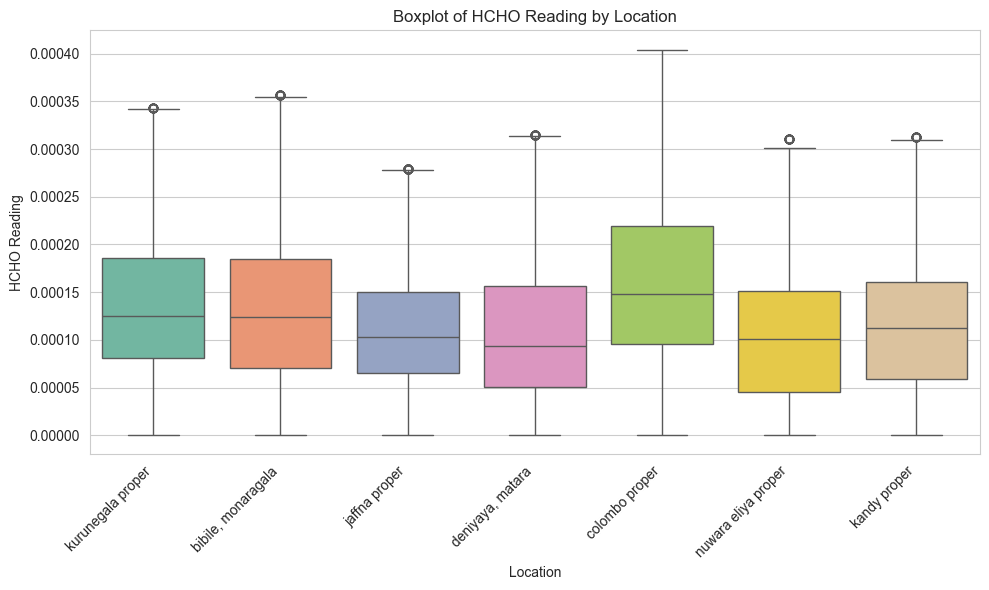

In [167]:
# HCHO level by locations
# figure and axes
fig, axs = plt.subplots(figsize=(10, 6))

# Boxplot for HCHO levels by Location
sns.boxplot(data=processed_df, x='Location', y='HCHO_reading', hue='Location', legend=False, palette='Set2')
plt.title('Boxplot of HCHO Reading by Location')
plt.xlabel('Location')
plt.ylabel('HCHO Reading')
plt.xticks(rotation=45, ha='right') 

# Show the plot
plt.tight_layout()
plt.show()

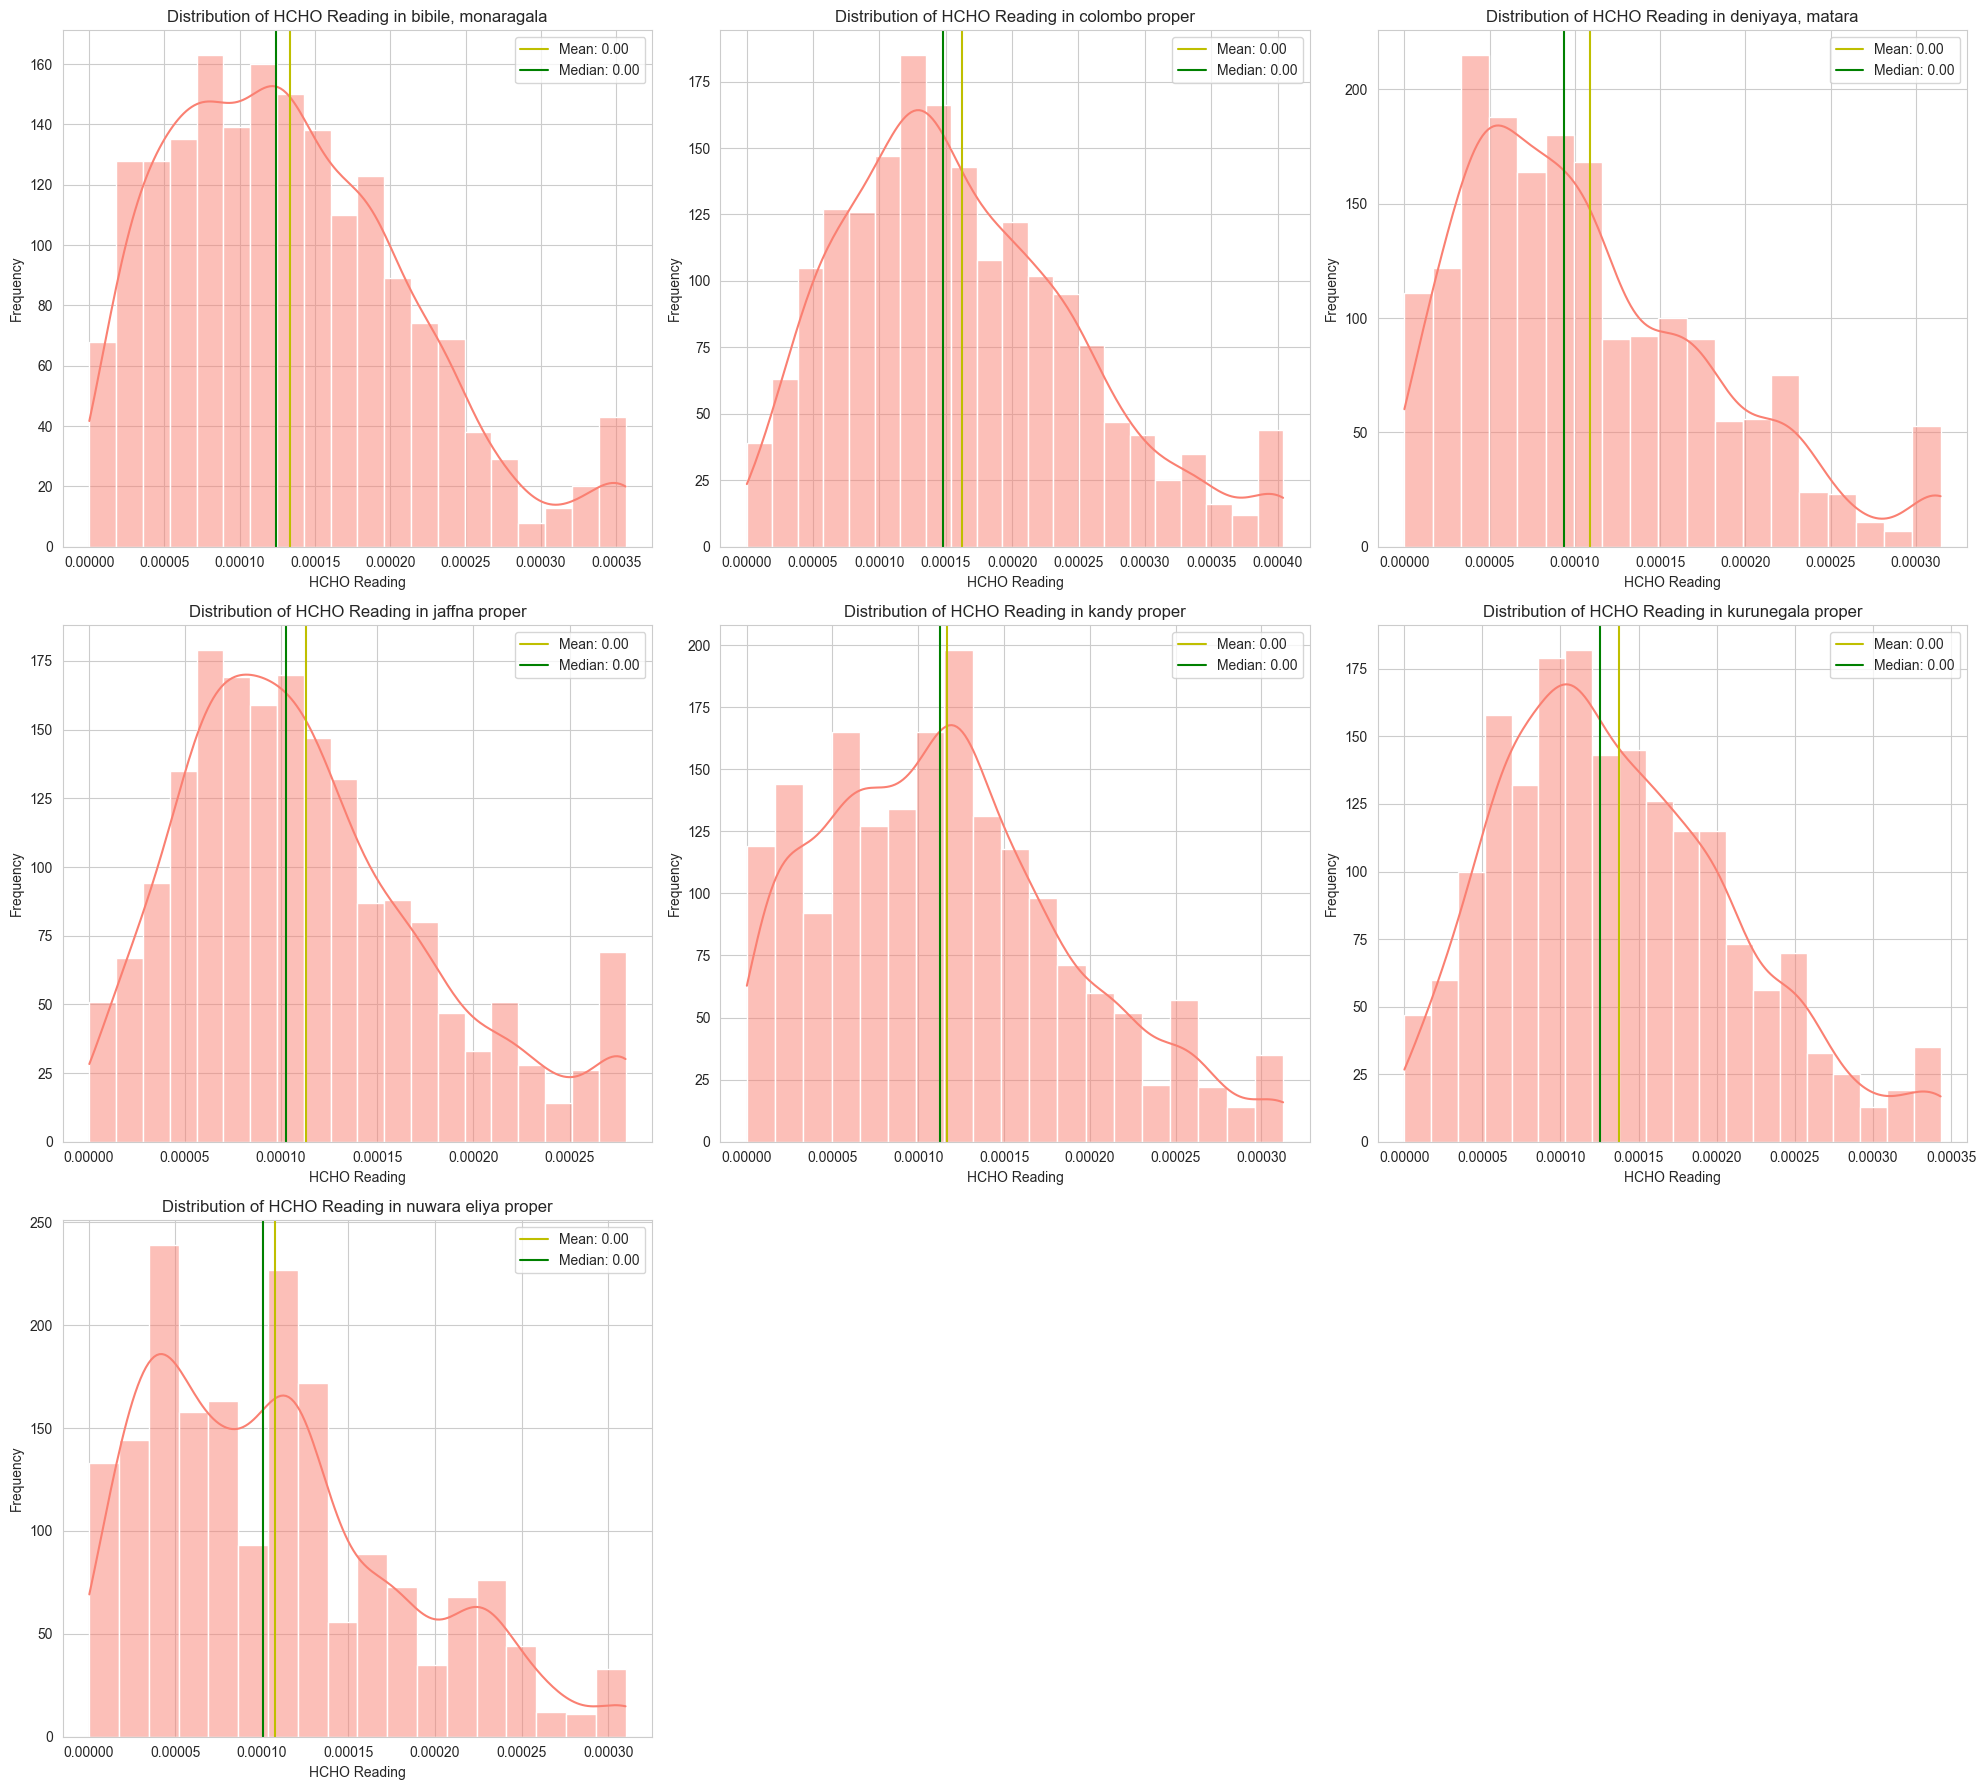

In [175]:
# subplots
num_cols = 3  # # of columns for subplots
num_rows = (len(processed_df['Location'].unique()) + num_cols - 1) // num_cols  # Calculate number of rows needed
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6*num_rows))

# flatten the axs array if it's a multi-dimensional array
if num_rows > 1:
    axs = axs.flatten()

# Plotting for each location
for i, (location, data) in enumerate(processed_df.groupby('Location')):
    # Calculate statistics for the current location
    mean = data['HCHO_reading'].mean()
    median = data['HCHO_reading'].median()
    std_dev = data['HCHO_reading'].std()
    
    # Plot distribution chart for the current location
    sns.histplot(data=data, x="HCHO_reading", kde=True, ax=axs[i], color='salmon')
    
    # Add mean, median, and standard deviation to the plot
    axs[i].axvline(mean, color='y', linestyle='-', label=f'Mean: {mean:.2f}')
    axs[i].axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f}')
    axs[i].legend()
    axs[i].set_xlabel("HCHO Reading")
    axs[i].set_ylabel("Frequency")
    axs[i].set_title(f"Distribution of HCHO Reading in {location}")

# Hide empty subplots if there are any
for j in range(len(processed_df['Location'].unique()), num_cols*num_rows):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

### HCHO distributions over past years

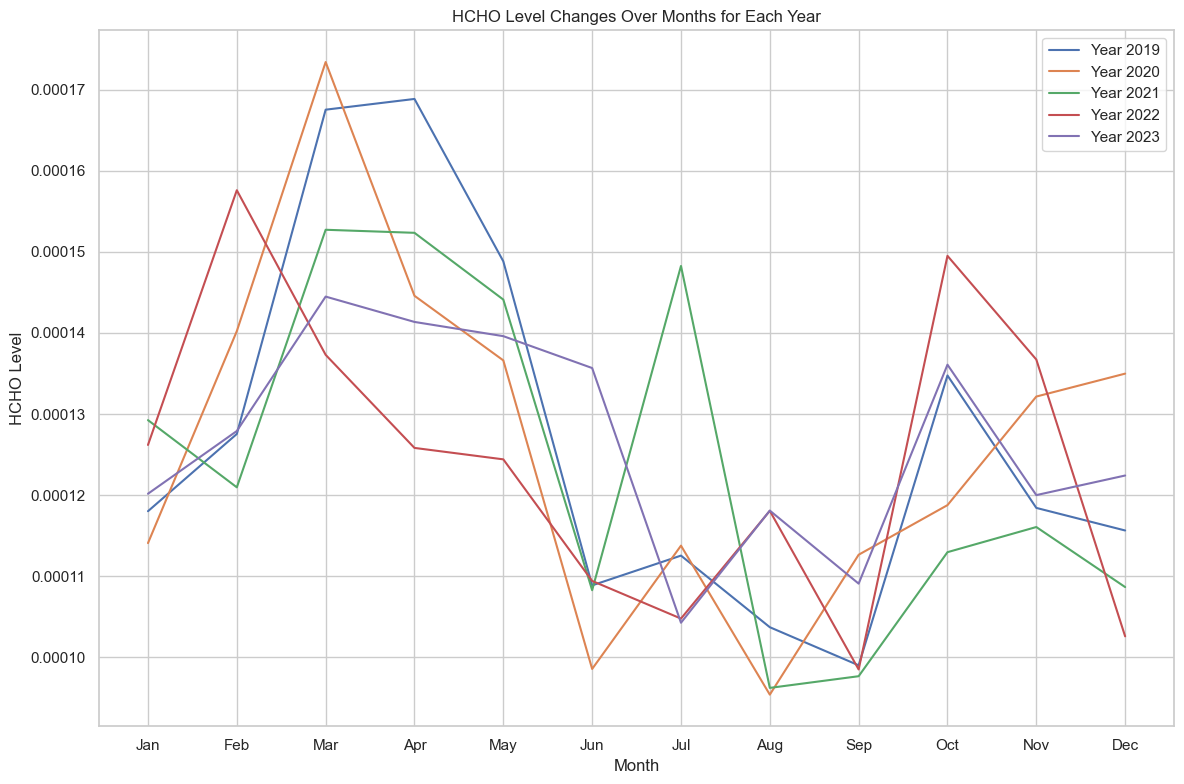

In [176]:
import calendar

processed_df['Current_Date'] = pd.to_datetime(processed_df['Current_Date'])

# get year and month from the Date column
processed_df['Year'] = processed_df['Current_Date'].dt.year
processed_df['Month'] = processed_df['Current_Date'].dt.month

# group data by year and month and calculate mean HCHO level
monthly_mean_hcho = processed_df.groupby(['Year', 'Month'])['HCHO_reading'].mean().reset_index()

# month names
month_names = [calendar.month_abbr[i] for i in range(1, 13)]

# plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# loop through each year and plot HCHO levels over months
for year in monthly_mean_hcho['Year'].unique():
    data_year = monthly_mean_hcho[monthly_mean_hcho['Year'] == year]
    plt.plot(data_year['Month'], data_year['HCHO_reading'], label=f'Year {year}')

plt.xlabel('Month')
plt.ylabel('HCHO Level')
plt.title('HCHO Level Changes Over Months for Each Year')
plt.xticks(range(1, 13), month_names)  # month names obtained from the calendar module
plt.legend()
plt.tight_layout()
plt.show()

In [178]:
# after cleaning
stats_after_cleaning = processed_df.groupby('Location')['HCHO_reading'].agg(['mean', 'median', 'std'])
print("\nDescriptive Statistics for HCHO Levels :")
print(stats_after_cleaning)


Descriptive Statistics for HCHO Levels :
                         mean    median       std
Location                                         
bibile, monaragala   0.000133  0.000124  0.000081
colombo proper       0.000162  0.000148  0.000090
deniyaya, matara     0.000109  0.000094  0.000074
jaffna proper        0.000113  0.000103  0.000065
kandy proper         0.000117  0.000113  0.000073
kurunegala proper    0.000137  0.000125  0.000075
nuwara eliya proper  0.000108  0.000101  0.000073
